Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import random
from sklearn.metrics import f1_score, recall_score
import matplotlib.pyplot as plt
import os
import json

Device Configuration

In [2]:
# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

device: cuda:0


Data Prep

In [3]:
# Download and load the CIFAR-100 dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_set = datasets.CIFAR100(root='../data', train=True, download=True, transform=transform)
test_set = datasets.CIFAR100(root='../data', train=False, download=True, transform=transform)

# Split train data into train and validation
train_size = int(0.8 * len(train_set))
val_size = len(train_set) - train_size
train_dataset, val_dataset = random_split(train_set, [train_size, val_size])

batch_size = 1024
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

100.0%


Extracting ../data\cifar-100-python.tar.gz to ../data
Files already downloaded and verified


Set Random Seed

In [4]:
# Function to set a random seed for reproducibility
def set_seed(seed=None):
    if seed is None:
        seed = np.random.randint(0, 10000)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    return seed

Validation

In [5]:
# Function for validation
def validate(net, val_loader, criterion):
    total_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
    return total_loss / len(val_loader)

Calculate Test Error

In [6]:
# Function to calculate test error
def calculate_test_error(net, test_loader):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_accuracy = 100 * correct / total
    return 100 - test_accuracy  # Test error

Train Model

In [7]:
# Function for training
def train_model(net, train_loader, val_loader, test_loader, criterion, optimizer, epochs):
    train_losses = []
    val_losses = []
    test_errors = []
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        train_losses.append(running_loss / len(train_loader))
        val_loss = validate(net, val_loader, criterion)
        val_losses.append(val_loss)
        test_error = calculate_test_error(net, test_loader)
        test_errors.append(test_error)
        print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}, Test Error: {test_errors[-1]}')

    return train_losses, val_losses, test_errors

Metrics Calculation

In [8]:
# Function to calculate accuracy, F1 score, and recall
def calculate_metrics(net, loader):
    net.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for data in loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    return accuracy, f1, recall

Model Architecture

In [9]:
# ResNet-18 with SE block

# SE block
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)


def initialize_model(device):
    net = models.resnet18(weights=None)
    num_features = net.fc.in_features

    # Adding an SE block
    net.avgpool = nn.Sequential(net.avgpool, SEBlock(num_features))

    # Adjusting for 100 classes in CIFAR-100
    net.fc = torch.nn.Linear(num_features, 100)
    net = net.to(device)

    return net

Loss Function

In [10]:
def initialize_loss_function():
    return nn.CrossEntropyLoss()

Optimizer

In [11]:
def initialize_optimizer(model_params):
    return optim.Adam(model_params, lr=0.001)

Run

Run: 1
Seed: 3306
Epoch 1/200, Train Loss: 3.7419519305229185, Validation Loss: 3.396400237083435, Test Error: 82.49
Epoch 2/200, Train Loss: 4.021823966503144, Validation Loss: 3.7474997997283936, Test Error: 88.32
Epoch 3/200, Train Loss: 3.449446040391922, Validation Loss: 3.3814974308013914, Test Error: 80.67
Epoch 4/200, Train Loss: 3.17761315703392, Validation Loss: 3.2195330619812013, Test Error: 78.14
Epoch 5/200, Train Loss: 2.9530762314796446, Validation Loss: 3.1947380781173704, Test Error: 77.35
Epoch 6/200, Train Loss: 2.7928257524967193, Validation Loss: 3.0631402492523194, Test Error: 74.21000000000001
Epoch 7/200, Train Loss: 2.607886737585068, Validation Loss: 3.0612196207046507, Test Error: 73.97
Epoch 8/200, Train Loss: 2.464850741624832, Validation Loss: 2.9943647146224976, Test Error: 71.78
Epoch 9/200, Train Loss: 2.2507535755634307, Validation Loss: 2.8178903341293333, Test Error: 68.69
Epoch 10/200, Train Loss: 2.067443186044693, Validation Loss: 2.9040604829788

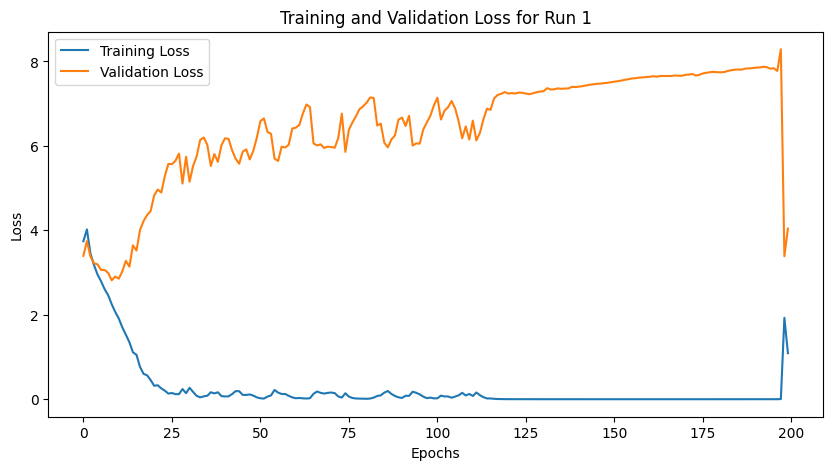

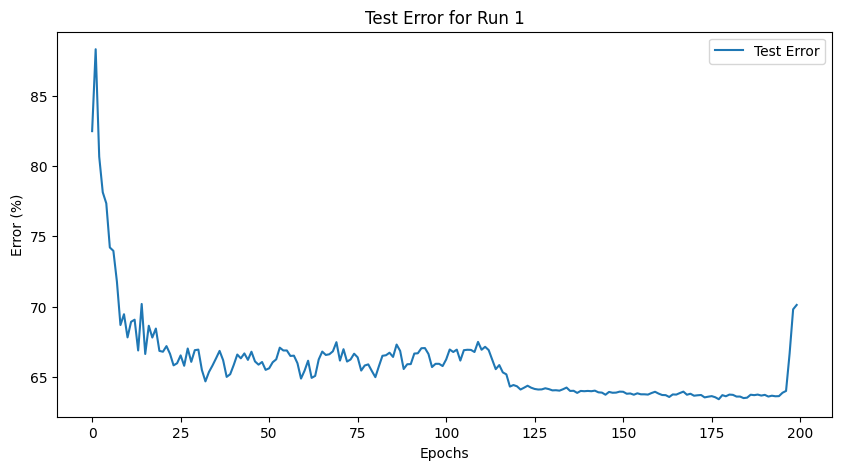

Run: 2
Seed: 982
Epoch 1/200, Train Loss: 3.7041865408420565, Validation Loss: 3.4032333850860597, Test Error: 83.42
Epoch 2/200, Train Loss: 4.018893927335739, Validation Loss: 3.659567880630493, Test Error: 86.52
Epoch 3/200, Train Loss: 3.401536059379578, Validation Loss: 3.509645867347717, Test Error: 83.75
Epoch 4/200, Train Loss: 3.1589132368564607, Validation Loss: 3.2544147968292236, Test Error: 78.48
Epoch 5/200, Train Loss: 2.984753304719925, Validation Loss: 3.207088756561279, Test Error: 76.78
Epoch 6/200, Train Loss: 2.794303905963898, Validation Loss: 3.294278645515442, Test Error: 78.88
Epoch 7/200, Train Loss: 2.632711631059647, Validation Loss: 3.067148804664612, Test Error: 72.89
Epoch 8/200, Train Loss: 2.476067978143692, Validation Loss: 2.808794045448303, Test Error: 69.59
Epoch 9/200, Train Loss: 2.251652705669403, Validation Loss: 3.086004400253296, Test Error: 72.21000000000001
Epoch 10/200, Train Loss: 2.158290684223175, Validation Loss: 2.8489139795303347, Tes

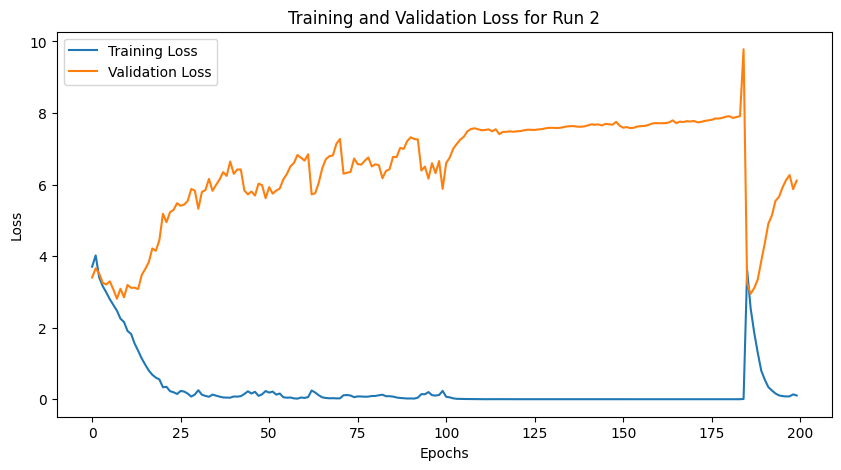

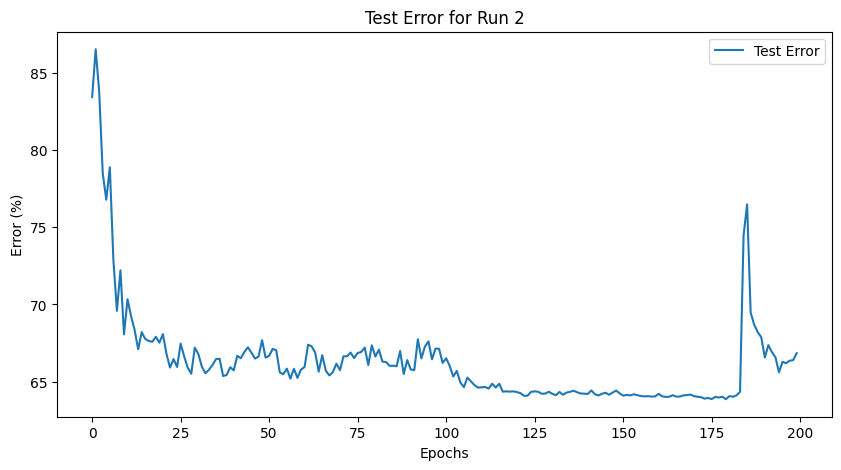

Run: 3
Seed: 7714
Epoch 1/200, Train Loss: 3.709537851810455, Validation Loss: 3.3338017225265504, Test Error: 82.49
Epoch 2/200, Train Loss: 4.1803096532821655, Validation Loss: 3.7677369356155395, Test Error: 88.74
Epoch 3/200, Train Loss: 3.5414438962936403, Validation Loss: 3.5636532068252564, Test Error: 83.28
Epoch 4/200, Train Loss: 3.2848748326301576, Validation Loss: 3.2868000268936157, Test Error: 79.88
Epoch 5/200, Train Loss: 3.0198850274085998, Validation Loss: 3.2537894248962402, Test Error: 77.91
Epoch 6/200, Train Loss: 2.8799232482910155, Validation Loss: 3.1026210308074953, Test Error: 75.73
Epoch 7/200, Train Loss: 2.7121107816696166, Validation Loss: 3.0556821823120117, Test Error: 74.76
Epoch 8/200, Train Loss: 2.563915330171585, Validation Loss: 3.047502303123474, Test Error: 73.32
Epoch 9/200, Train Loss: 2.443977403640747, Validation Loss: 2.8339364290237428, Test Error: 69.27
Epoch 10/200, Train Loss: 2.2492491602897644, Validation Loss: 2.7912383317947387, Tes

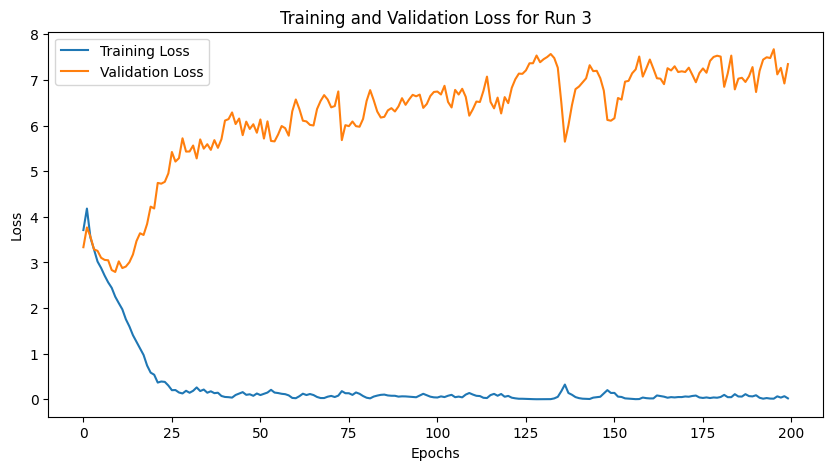

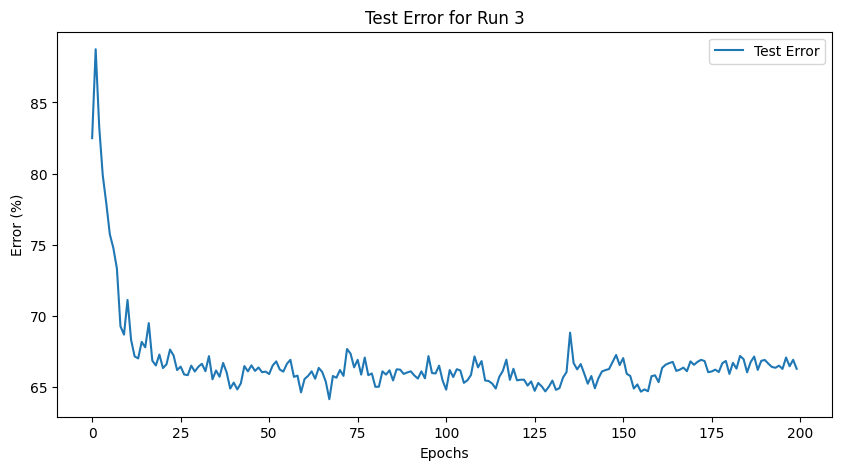

Run: 4
Seed: 5758
Epoch 1/200, Train Loss: 3.714728993177414, Validation Loss: 3.366001033782959, Test Error: 81.82
Epoch 2/200, Train Loss: 4.184383225440979, Validation Loss: 3.8114734172821043, Test Error: 89.15
Epoch 3/200, Train Loss: 3.552557873725891, Validation Loss: 3.5870463371276857, Test Error: 84.59
Epoch 4/200, Train Loss: 3.3064086616039274, Validation Loss: 3.345093560218811, Test Error: 80.63
Epoch 5/200, Train Loss: 3.094469875097275, Validation Loss: 3.2441272258758547, Test Error: 77.64
Epoch 6/200, Train Loss: 2.9202855587005616, Validation Loss: 3.1827029943466187, Test Error: 76.42
Epoch 7/200, Train Loss: 2.7997414827346803, Validation Loss: 2.940730333328247, Test Error: 72.45
Epoch 8/200, Train Loss: 2.6107362508773804, Validation Loss: 3.019310474395752, Test Error: 72.89
Epoch 9/200, Train Loss: 2.4588759183883666, Validation Loss: 2.886491870880127, Test Error: 70.14
Epoch 10/200, Train Loss: 2.3211812019348144, Validation Loss: 2.8966597080230714, Test Err

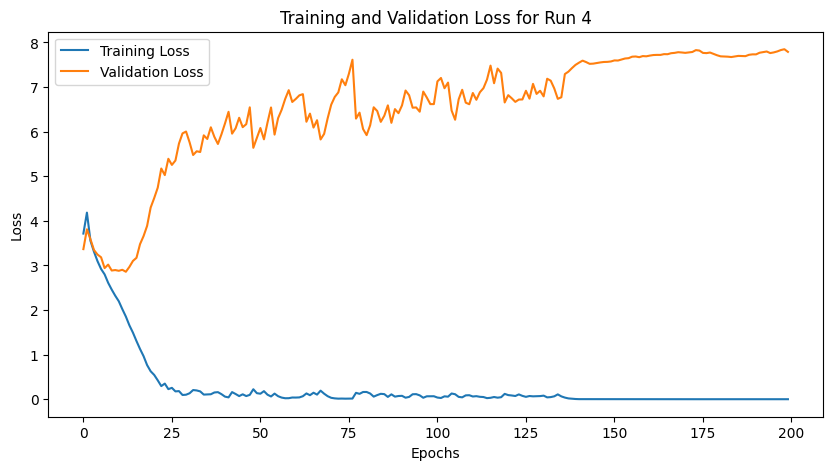

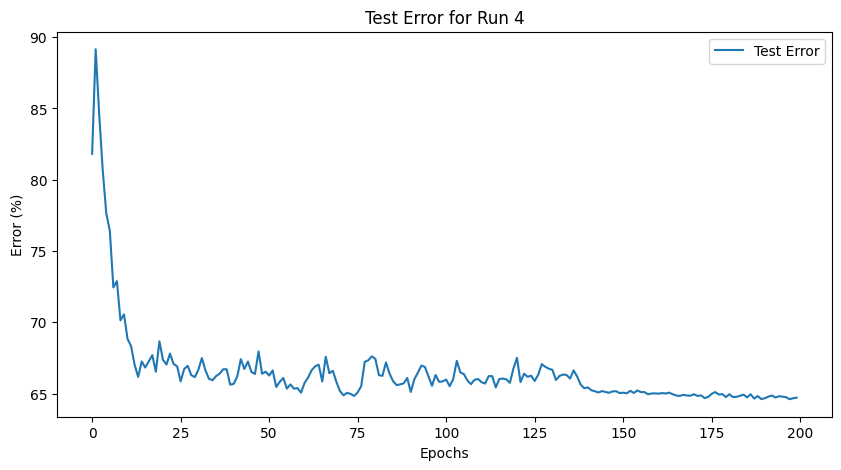

Run: 5
Seed: 8542
Epoch 1/200, Train Loss: 3.7156195282936095, Validation Loss: 3.394293999671936, Test Error: 82.61
Epoch 2/200, Train Loss: 4.159742748737335, Validation Loss: 3.854844903945923, Test Error: 90.27
Epoch 3/200, Train Loss: 3.5593040585517883, Validation Loss: 3.6061182022094727, Test Error: 84.42
Epoch 4/200, Train Loss: 3.3150114476680757, Validation Loss: 3.3432246923446653, Test Error: 80.26
Epoch 5/200, Train Loss: 3.0800715923309325, Validation Loss: 3.371617889404297, Test Error: 80.34
Epoch 6/200, Train Loss: 2.8951751232147216, Validation Loss: 3.063941216468811, Test Error: 73.94
Epoch 7/200, Train Loss: 2.7261013984680176, Validation Loss: 2.984554409980774, Test Error: 72.92
Epoch 8/200, Train Loss: 2.581628978252411, Validation Loss: 3.153983211517334, Test Error: 74.6
Epoch 9/200, Train Loss: 2.4308218955993652, Validation Loss: 2.982980179786682, Test Error: 71.38
Epoch 10/200, Train Loss: 2.287890154123306, Validation Loss: 2.8793838739395143, Test Error

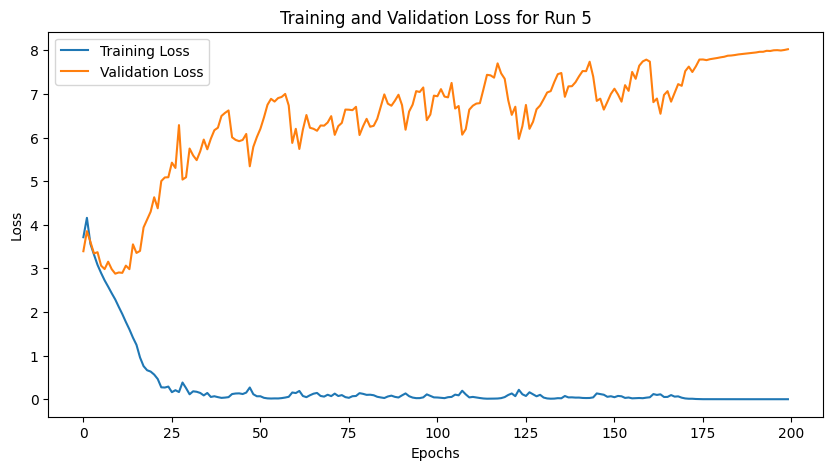

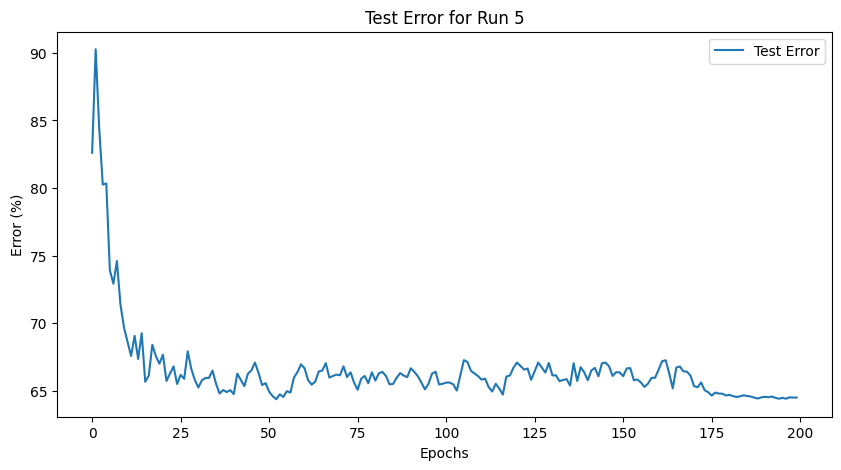

In [12]:
# Run the training for 5 different seeds
num_runs = 5
epochs = 200
metrics = {
    'seed': [],
    'train_losses': [],
    'val_losses': [],
    'test_errors': [],
    'val_accuracy': [],
    'val_f1': [],
    'val_recall': [],
    'test_accuracy': [],
    'test_f1': [],
    'test_recall': []
}



# Initialize dictionaries to store results
results = {
    'train_losses': [],
    'val_losses': [],
    'test_errors': []
}

for run in range(num_runs):
    print(f"Run: {run + 1}")
    seed = set_seed()
    print(f"Seed: {seed}")

    # Reinitialize the model, loss function, and optimizer
    net = initialize_model(device=device)
    criterion = initialize_loss_function()
    optimizer = initialize_optimizer(model_params=net.parameters())

    # Train the network
    train_losses, val_losses, test_errors = train_model(net, train_loader, val_loader, test_loader, criterion, optimizer, epochs)
    metrics['test_errors'].append(test_errors)

    # Calculate metrics on validation and test sets
    val_accuracy, val_f1, val_recall = calculate_metrics(net, val_loader)
    test_accuracy, test_f1, test_recall = calculate_metrics(net, test_loader)
    
    # Print metrics for validation set
    print(f"Run {run + 1} - Validation Metrics:")
    print(f"    Accuracy: {val_accuracy}%")
    print(f"    F1 Score: {val_f1}")
    print(f"    Recall:   {val_recall}")

    # Print metrics for test set
    print(f"Run {run + 1} - Test Metrics:")
    print(f"    Accuracy: {test_accuracy}%")
    print(f"    F1 Score: {test_f1}")
    print(f"    Recall:   {test_recall}")
    
    # Store metrics
    metrics['seed'].append(seed)
    metrics['train_losses'].append(train_losses)
    metrics['val_losses'].append(val_losses)
    metrics['val_accuracy'].append(val_accuracy)
    metrics['val_f1'].append(val_f1)
    metrics['val_recall'].append(val_recall)
    metrics['test_accuracy'].append(test_accuracy)
    metrics['test_f1'].append(test_f1)
    metrics['test_recall'].append(test_recall)
    
    # Append the results for the current run
    results['train_losses'].append(metrics['train_losses'][run])
    results['val_losses'].append(metrics['val_losses'][run])
    results['test_errors'].append(metrics['test_errors'][run])

    # Plot for training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(metrics['train_losses'][run], label='Training Loss')
    plt.plot(metrics['val_losses'][run], label='Validation Loss')
    plt.title(f"Training and Validation Loss for Run {run+1}")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot for test error
    plt.figure(figsize=(10, 5))
    plt.plot(metrics['test_errors'][run], label='Test Error')
    plt.title(f"Test Error for Run {run+1}")
    plt.xlabel('Epochs')
    plt.ylabel('Error (%)')
    plt.legend()
    plt.show()

Metrics Calculation and Plotting Mean Test Error

Mean Metrics: {'val_accuracy': 33.048, 'val_f1': 0.3275613690449689, 'val_recall': 0.33048, 'test_accuracy': 33.504000000000005, 'test_f1': 0.33286588416506824, 'test_recall': 0.33504}
Standard Deviation of Metrics: {'val_accuracy': 1.9777300119075916, 'val_f1': 0.020518846351449915, 'val_recall': 0.019777300119075917, 'test_accuracy': 2.020085146720307, 'test_f1': 0.02157003322993319, 'test_recall': 0.020200851467203056}


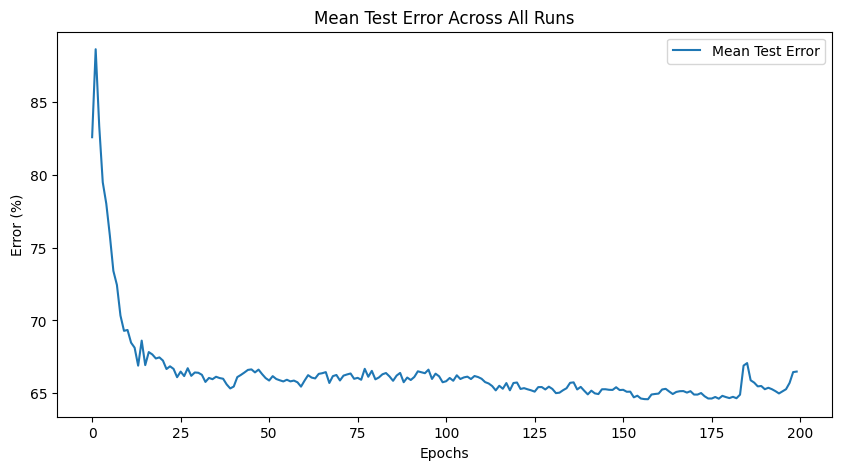

In [13]:
# Calculate mean and standard deviation across runs
mean_metrics = {metric: np.mean(metrics[metric]) for metric in metrics if metric not in ['seed', 'train_losses', 'val_losses', 'test_errors']}
std_metrics = {metric: np.std(metrics[metric]) for metric in metrics if metric not in ['seed', 'train_losses', 'val_losses', 'test_errors']}

# Print mean metrics and standard deviation
print("Mean Metrics:", mean_metrics)
print("Standard Deviation of Metrics:", std_metrics)

# Calculate mean test error across all runs
mean_test_errors = np.mean(metrics['test_errors'], axis=0)

# Plot mean test error
plt.figure(figsize=(10, 5))
plt.plot(mean_test_errors, label='Mean Test Error')
plt.title("Mean Test Error Across All Runs")
plt.xlabel('Epochs')
plt.ylabel('Error (%)')
plt.legend()
plt.show()

Save data

In [14]:
# Directory for saving results
save_dir = 'CIFAR_100_RN18_AL_Results'
os.makedirs(save_dir, exist_ok=True)

# Save the results to a file
with open(os.path.join(save_dir, 'ADAM.json'), 'w') as f:
    json.dump(results, f)